## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 70 kB 9.2 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 288 kB 83.2 MB/s 
     |████████████████████████████████| 1.1 MB 76.0 MB/s 
     |████████████████████████████████| 112 kB 95.8 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 271 kB 101.8 MB/s 
     |████████████████████████████████| 144 kB 101.2 MB/s 
     |████████████████████████████████| 749 kB 64.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (168749, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [6]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 10000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 10000 steps
Generated time-series
Normalized 'candles_norm' with shape : (10000, 9)
Feature data 'x_candles' with size : 9952
Feature data with time intervals 'x_time' with size : 9952


[0.36872481938241763,
 0.36744321984130246,
 0.36391035358708573,
 0.363004238310503,
 0.3631644837774227,
 0.36232192039624345,
 0.3630679723030279,
 0.36659391886662757,
 0.36102083646312766,
 0.361517597410579]

## Train CNN-LSTM model using full data set

In [7]:
btc_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
btc_model.sats2model()

In [8]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220615_18_16'

In [9]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220615_18_16"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, epochs=20)

Epoch 1/20
3/3 [==============================] - 24s 2s/step - loss: 0.4444 - val_loss: 0.1335
Epoch 2/20
3/3 [==============================] - 0s 155ms/step - loss: 0.1355 - val_loss: 0.0474
Epoch 3/20
3/3 [==============================] - 0s 165ms/step - loss: 0.0722 - val_loss: 0.1147
Epoch 4/20
3/3 [==============================] - 0s 107ms/step - loss: 0.0861 - val_loss: 0.0615
Epoch 5/20
3/3 [==============================] - 0s 153ms/step - loss: 0.0720 - val_loss: 0.0342
Epoch 6/20
3/3 [==============================] - 0s 166ms/step - loss: 0.0438 - val_loss: 0.0624
Epoch 7/20
3/3 [==============================] - 0s 107ms/step - loss: 0.0527 - val_loss: 0.0371
Epoch 8/20
3/3 [==============================] - 0s 107ms/step - loss: 0.0439 - val_loss: 0.0344
Epoch 9/20
3/3 [==============================] - 0s 150ms/step - loss: 0.0359 - val_loss: 0.0430
Epoch 10/20
3/3 [==============================] - 0s 107ms/step - loss: 0.0399 - val_loss: 0.0316
Epoch 11/20
3/3 [====

INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220615_18_16/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220615_18_16/assets


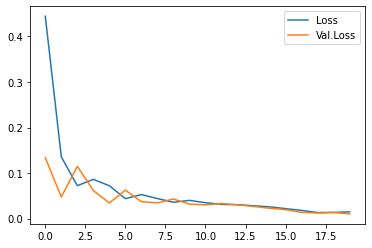

In [10]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [11]:
btc_model.sats2train(model_name, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 192ms/step - loss: 0.0134 - val_loss: 0.0122
Epoch 2/100
3/3 [==============================] - 0s 108ms/step - loss: 0.0146 - val_loss: 0.0087
Epoch 3/100
3/3 [==============================] - 0s 157ms/step - loss: 0.0133 - val_loss: 0.0082
Epoch 4/100
3/3 [==============================] - 0s 154ms/step - loss: 0.0120 - val_loss: 0.0052
Epoch 5/100
3/3 [==============================] - 0s 164ms/step - loss: 0.0090 - val_loss: 0.0048
Epoch 6/100
3/3 [==============================] - 0s 108ms/step - loss: 0.0217 - val_loss: 0.0195
Epoch 7/100
3/3 [==============================] - 0s 108ms/step - loss: 0.0198 - val_loss: 0.0215
Epoch 8/100
3/3 [==============================] - 0s 107ms/step - loss: 0.0173 - val_loss: 0.0256
Epoch 9/100
3/3 [==============================] - 0s 108ms/step - loss: 0.0224 - val_loss: 0.0147
Epoch 10/100
3/3 [==============================] - 0s 107ms/step - loss: 0.0131 - val_loss: 0.0145
Epoch 11/

INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220615_18_16/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220615_18_16/assets


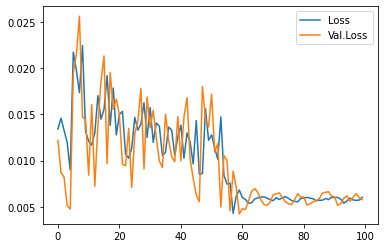

In [12]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [13]:
btc_model.sats2pred(predict_on_test = False)
btc_model.preds

array([[0.54934156],
       [0.5490832 ],
       [0.5488311 ],
       ...,
       [0.3529375 ],
       [0.35295606],
       [0.35245302]], dtype=float32)

## Test on pretrained model

In [24]:
USE_PRETRAINED = True

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
loaded_model.sats2model()
loaded_model.load_model(model_name)
#loaded_model.train_test_split()
loaded_model.sats2pred(predict_on_test = False)
loaded_model.preds

array([[0.54934156],
       [0.5490832 ],
       [0.5488311 ],
       ...,
       [0.3529375 ],
       [0.35295606],
       [0.35245302]], dtype=float32)

In [27]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(loaded_model.preds)

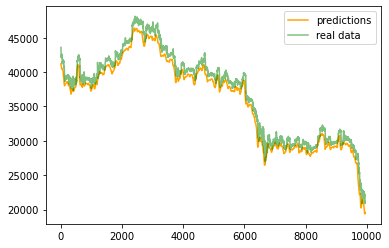

In [31]:
plt.plot(preds[0:len(ts_btc.x_candles)-loaded_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

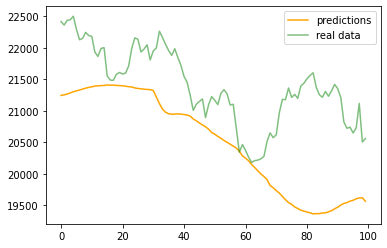

In [29]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Predict the last time step, so should predict following close price

In [32]:
norm_new_y = loaded_model.model.predict([loaded_model.x_candles[-1:], loaded_model.x_time[-1:]], batch_size=btc_model.batch_size)
pred_new_y = ts_btc.denorm(norm_new_y)
last_y = ts_btc.denorm(ts_btc.candles_norm[-1:,-1:])
last_y_candle = ts_btc.candles.iloc[-1,-1]
last_y_time = ts_btc.candles.index[-1]

In [33]:
pred_new_y

[19564.14421707093]

In [34]:
last_y_candle

20559.72

In [35]:
last_y_time

Timestamp('2022-06-15 18:16:00')

## Download new data, generate features and time series

In [22]:
ldata_df_new = crypto.load_cryptos(tickers,save = False)
new_can_btc = fb.Candles(ldata_df_new,"Bitcoin")
new_can_btc.buildfeatures()
new_ts_btc = c2t.Candle2TimeSeries(new_can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

new_ts_btc.candles2ts()

All caught up..!
size of dataset: (168749, 8)
Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [23]:
last_new_y_time = new_ts_btc.candles.index[-1]
last_new_y_times = new_ts_btc.candles.index [ new_ts_btc.candles.index >= last_y_time ]
new_time_steps = len(last_new_y_times)
last_new_y_times

DatetimeIndex(['2022-06-15 18:16:00'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
new_ts_btc.x_candles = np.asarray(new_ts_btc.x_candles, dtype=np.float32)
new_ts_btc.x_time = np.asarray(new_ts_btc.x_time, dtype=np.float32)

norm_new_y = btc_model.model.predict([new_ts_btc.x_candles[-new_time_steps:], new_ts_btc.x_time[-new_time_steps:]], batch_size=btc_model.batch_size)
pred_new_y = ts_btc.denorm(norm_new_y)
true_last_y = ts_btc.denorm(ts_btc.candles_norm[-new_time_steps:,-1])
new_y_candles = ts_btc.candles.iloc[-new_time_steps:,-1]

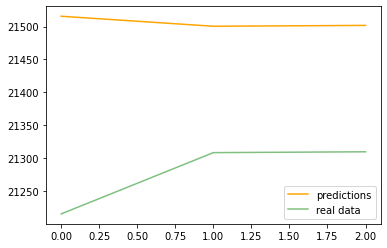

In [ ]:
plt.plot(pred_new_y, color='orange', label='predictions')
plt.plot(true_last_y, color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()